<a href="https://colab.research.google.com/github/poperskop/Yulu-Bike-Rentals/blob/main/Yulu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
#from sklego.preprocessing import RepeatingBasisFunction
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.1 MB/s eta 0:00:00


In [4]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import catboost

In [5]:
df = pd.read_csv('Yulu.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
display(df.describe())

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [8]:
num = ['temp', 'humidity', 'windspeed']
cat = ['season', 'holiday', 'workingday', 'weather', 'time']

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['time'] = df['datetime'].dt.hour
df.drop(['atemp', 'datetime', 'registered', 'casual'], inplace=True, axis=1)
df.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,time
0,1,0,0,1,9.84,81,0.0,16,0
1,1,0,0,1,9.02,80,0.0,40,1
2,1,0,0,1,9.02,80,0.0,32,2
3,1,0,0,1,9.84,75,0.0,13,3
4,1,0,0,1,9.84,75,0.0,1,4


<Axes: >

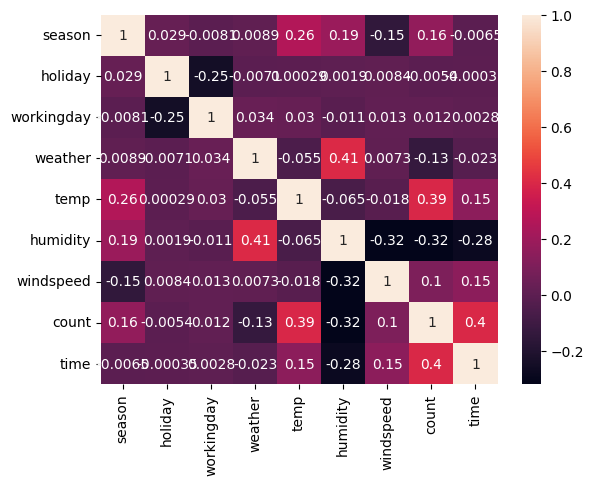

In [10]:
sns.heatmap(df.corr(), annot=True)

<Axes: xlabel='time', ylabel='count'>

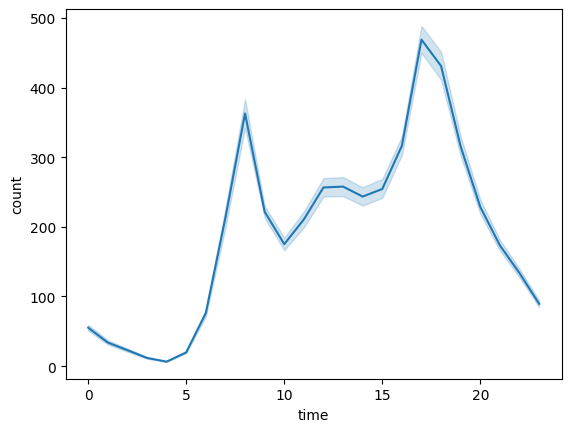

In [11]:
sns.lineplot(data=df, x='time', y='count')

In [12]:
features = df.drop(['count'], axis=1)
target = df['count']

In [13]:
from sklearn.model_selection import train_test_split,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=23)

In [14]:
simple_imputer = SimpleImputer(strategy='median')
std_scaler = StandardScaler()
pipe_num = Pipeline([('imputer', simple_imputer), ('scaler', std_scaler)])

s_imputer = SimpleImputer(strategy='constant', fill_value=-1)
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
pipe_cat = Pipeline([('imputer', s_imputer), ('encoder', ohe_encoder)])

col_transformer = ColumnTransformer([('num_preproc', pipe_num, [x for x in features.columns if features[x].dtype!='object']),
                                     ('cat_preproc', pipe_cat, [x for x in features.columns if features[x].dtype=='object'])])

model = RandomForestRegressor()
pipe = Pipeline([('preproc', col_transformer),
                       ('model', model)])

In [15]:
model = RandomForestRegressor()
pipe_forest = Pipeline([('preproc', col_transformer),
                       ('model', model)])
pipe_forest.fit(X_train, y_train)
predictionsf = pipe_forest.predict(X_test)
mean_absolute_percentage_error(y_test, predictionsf)

0.4609270810366968

In [16]:
model = catboost.CatBoostRegressor(loss_function='MAPE')

pipe_cat = Pipeline([('preproc', col_transformer),
                       ('model', model)])
pipe_cat.fit(X_train, y_train)
predictionsc = pipe_cat.predict(X_test)
mean_absolute_percentage_error(y_test, predictionsc)

0:	learn: 0.9052802	total: 49.7ms	remaining: 49.7s
1:	learn: 0.8989085	total: 56.1ms	remaining: 28s
2:	learn: 0.8856225	total: 60.7ms	remaining: 20.2s
3:	learn: 0.8729927	total: 64.8ms	remaining: 16.1s
4:	learn: 0.8591345	total: 68.9ms	remaining: 13.7s
5:	learn: 0.8538968	total: 73.3ms	remaining: 12.1s
6:	learn: 0.8432322	total: 77.5ms	remaining: 11s
7:	learn: 0.8368718	total: 81.8ms	remaining: 10.1s
8:	learn: 0.8331327	total: 87.4ms	remaining: 9.62s
9:	learn: 0.8227361	total: 91.9ms	remaining: 9.09s
10:	learn: 0.8130789	total: 95.7ms	remaining: 8.61s
11:	learn: 0.8069983	total: 97.5ms	remaining: 8.03s
12:	learn: 0.7996300	total: 100ms	remaining: 7.6s
13:	learn: 0.7942792	total: 102ms	remaining: 7.21s
14:	learn: 0.7872080	total: 105ms	remaining: 6.9s
15:	learn: 0.7806279	total: 108ms	remaining: 6.65s
16:	learn: 0.7717499	total: 114ms	remaining: 6.57s
17:	learn: 0.7696563	total: 117ms	remaining: 6.39s
18:	learn: 0.7624088	total: 122ms	remaining: 6.27s
19:	learn: 0.7578919	total: 126ms	r

0.5521940332517831

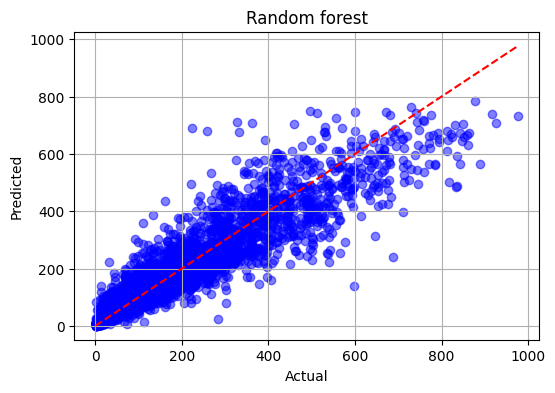

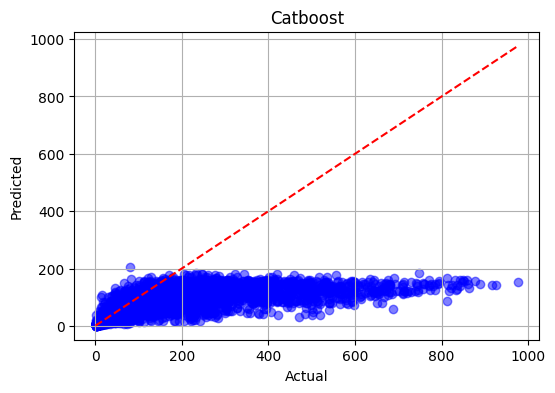

In [18]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, predictionsf, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random forest')
plt.grid(True)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, predictionsc, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Catboost')
plt.grid(True)

plt.show()